In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../src') 

from utils.data_loader import load_data

# Load data
df = load_data('../data/raw_analyst_ratings.csv')
# print(df.head())

Data loaded successfully from ../data/raw_analyst_ratings.csv


Data Preparation and Cleaning

1. Summary Statistics & Missing-Value Report

1.1 Summary Statistics

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407328 entries, 0 to 1407327
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   date       1407328 non-null  object
 4   stock      1407328 non-null  object
dtypes: object(5)
memory usage: 53.7+ MB


In [3]:
df.describe()

,headline,url,publisher,date,stock
count,1407328,1407328,1407328,1407328,1407328
unique,845770,883429,1034,39957,6204
top,Benzinga's Top Upgrades,https://www.benzinga.com/news/20/03/15538835/s...,Paul Quintaro,2020-03-12 00:00:00,MRK
freq,5449,1704,228373,1766,3333


1.2 Missing-Value Report and removal

In [4]:
df.isna().sum()

headline     0
url          0
publisher    0
date         0
stock        0
dtype: int64

2. Check and remove duplicate entries

In [5]:
#display number of duplicates
print(df.duplicated().sum())

1


In [6]:
# print the original plus the duplicate
print(df[df.duplicated(keep=False)])

                                          headline  \
559383  Top Performing Industries For July 1, 2015   
559384  Top Performing Industries For July 1, 2015   

                                                      url   publisher  \
559383  https://www.benzinga.com/news/15/07/5642290/to...  Lisa Levin   
559384  https://www.benzinga.com/news/15/07/5642290/to...  Lisa Levin   

                       date stock  
559383  2015-07-01 00:00:00   GME  
559384  2015-07-01 00:00:00   GME  


In [7]:
# Remove duplicates
df = df.drop_duplicates() 
print(df.duplicated().sum())

0


3. Convert type of date to timestamp

In [8]:
# convert date to timestamp

df['date'] = pd.to_datetime(df['date'], format='mixed', utc=True)
print(df['date'])

0         2020-06-05 14:30:54+00:00
1         2020-06-03 14:45:20+00:00
2         2020-05-26 08:30:07+00:00
3         2020-05-22 16:45:06+00:00
4         2020-05-22 15:38:59+00:00
                     ...           
1407323   2011-08-29 00:00:00+00:00
1407324   2011-06-22 00:00:00+00:00
1407325   2011-06-21 00:00:00+00:00
1407326   2011-06-21 00:00:00+00:00
1407327   2011-05-12 00:00:00+00:00
Name: date, Length: 1407327, dtype: datetime64[ns, UTC]


In [9]:
# Convert all times to a consistent timezone

df['date'] = df['date'].dt.tz_convert('UTC')
print(df['date'])

0         2020-06-05 14:30:54+00:00
1         2020-06-03 14:45:20+00:00
2         2020-05-26 08:30:07+00:00
3         2020-05-22 16:45:06+00:00
4         2020-05-22 15:38:59+00:00
                     ...           
1407323   2011-08-29 00:00:00+00:00
1407324   2011-06-22 00:00:00+00:00
1407325   2011-06-21 00:00:00+00:00
1407326   2011-06-21 00:00:00+00:00
1407327   2011-05-12 00:00:00+00:00
Name: date, Length: 1407327, dtype: datetime64[ns, UTC]


In [10]:
# extract time frames for later analysis

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour
df['published_date'] = df['date'].dt.date


4. Cleaning Stock Ticker Symbols 

In [11]:
# Standardize ticker format (uppercase, no spaces)

df['stock'] = df['stock'].str.upper().str.strip()
df['stock']

0           A
1           A
2           A
3           A
4           A
           ..
1407323    ZX
1407324    ZX
1407325    ZX
1407326    ZX
1407327    ZX
Name: stock, Length: 1407327, dtype: object

5. Check and remove invalid urls

In [12]:
# remove malformed URLs (if any)
df = df[df['url'].str.startswith(('http://', 'https://'), na=False)]


6. Sentiment & NLP Preparation 

In [13]:
# 6.1 Tokenize headlines (split into words)

from nltk.tokenize import word_tokenize
df['headline_tokens'] = df['headline'.lower()].apply(word_tokenize)
df['headline_tokens']

0            [Stocks, That, Hit, 52-Week, Highs, On, Friday]
1          [Stocks, That, Hit, 52-Week, Highs, On, Wednes...
2                        [71, Biggest, Movers, From, Friday]
3          [46, Stocks, Moving, In, Friday, 's, Mid-Day, ...
4          [B, of, A, Securities, Maintains, Neutral, on,...
                                 ...                        
1407323       [Top, Narrow, Based, Indexes, For, August, 29]
1407324    [Recap, :, Wednesday, 's, Top, Percentage, Gai...
1407325    [UPDATE, :, Oppenheimer, Color, on, China, Zen...
1407326    [Oppenheimer, Initiates, China, Zenix, At, Out...
1407327    [China, Zenix, Auto, International, Opens, For...
Name: headline_tokens, Length: 1407327, dtype: object

In [14]:
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from utils.utils import setup_financial_stopwords, clean_financial_text
from nltk.stem import WordNetLemmatizer

# Download NLTK resources (if not already)
nltk.download(['stopwords', 'punkt', 'wordnet'])

# Prepare tools
financial_stopwords = setup_financial_stopwords()
lemmatizer = WordNetLemmatizer()

# Apply cleaning
df['cleaned_headline'] = df['headline'].apply(
    lambda x: clean_financial_text(x, financial_stopwords, lemmatizer)
)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
df.dtypes

headline                         object
url                              object
publisher                        object
date                datetime64[ns, UTC]
stock                            object
year                              int32
month                             int32
day_of_week                      object
hour                              int32
published_date                   object
headline_tokens                  object
cleaned_headline                 object
dtype: object

In [16]:
# save cleaned data
df.to_csv('../data/cleaned_analyst_ratings.csv', index=False)

Discriptive Analysis

1. Headline Length Statistics

In [17]:
# column for headline length (in characters)
df['headline_length_chars'] = df['headline'].str.len()

# column for headline length (in words)
df['headline_length_words'] = df['headline'].str.split().str.len()

# Summary statistics
df[['headline_length_chars', 'headline_length_words']].describe()

,headline_length_chars,headline_length_words
count,1.407327e+06,1.407327e+06
mean,7.312054e+01,1.141671e+01
std,4.073532e+01,6.352998e+00
min,3.000000e+00,1.000000e+00
25%,4.700000e+01,7.000000e+00
50%,6.400000e+01,1.000000e+01
75%,8.700000e+01,1.300000e+01
max,5.120000e+02,7.700000e+01


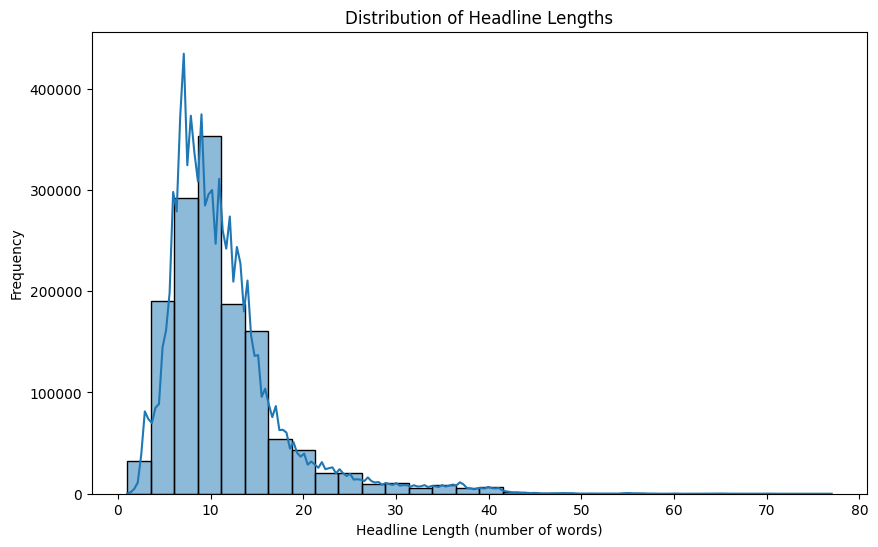

In [18]:
# headline length
def plot_headline_length_distribution(df):
    """
    Plot the distribution of headline lengths.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing the dataset.
    """
    if 'headline' in df.columns:
        df['headline_length'] = df['headline'].apply(lambda x: len(str(x).split()))
        plt.figure(figsize=(10, 6))
        sns.histplot(df['headline_length'], bins=30, kde=True)
        plt.title('Distribution of Headline Lengths')
        plt.xlabel('Headline Length (number of words)')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("Error: 'headline' column not found in the DataFrame.")
plot_headline_length_distribution(df)

In [19]:
df['headline_length'].describe()

count    1.407327e+06
mean     1.141671e+01
std      6.352998e+00
min      1.000000e+00
25%      7.000000e+00
50%      1.000000e+01
75%      1.300000e+01
max      7.700000e+01
Name: headline_length, dtype: float64

2. Count articels by publishers

In [20]:
publisher_counts = df['publisher'].value_counts()

# Top 10 publishers
top_publishers = publisher_counts.head(10)
top_publishers


publisher
Paul Quintaro        228373
Lisa Levin           186978
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64

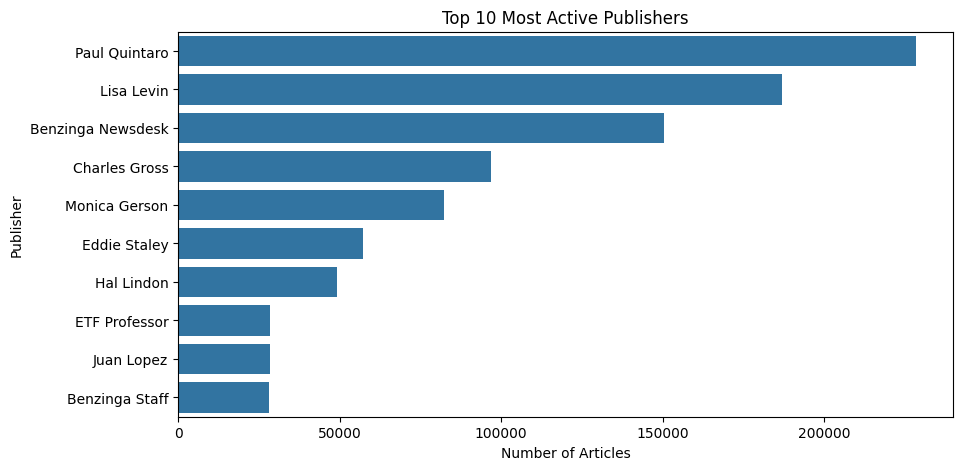

In [21]:
plt.figure(figsize=(10, 5))
sns.barplot(x=top_publishers.values, y=top_publishers.index)
plt.title('Top 10 Most Active Publishers')
plt.xlabel('Number of Articles')
plt.ylabel('Publisher')
plt.show()


3. Publication Trends Over Time

In [22]:
daily_counts = df.groupby('publish_date').size()

# Plot daily trend
plt.figure(figsize=(14, 5))
daily_counts.plot()
plt.title('Articles Published Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()


KeyError: 'publish_date'

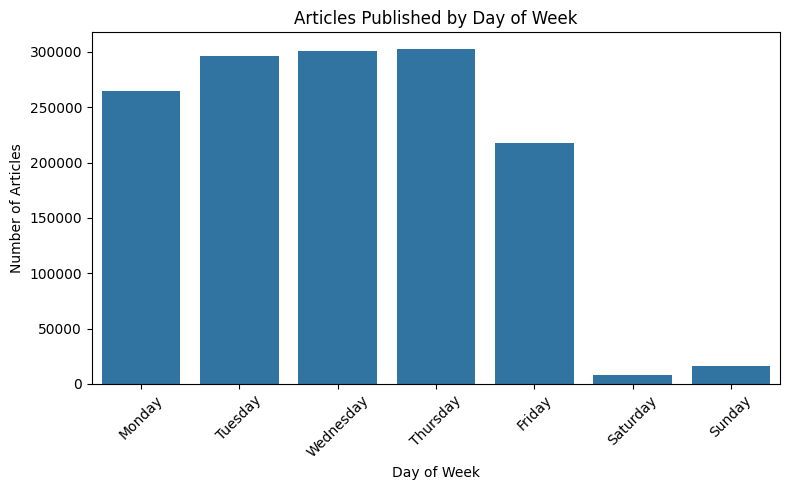

In [ ]:
dow_counts = df['day_of_week'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

plt.figure(figsize=(8, 5))
sns.barplot(x=dow_counts.index, y=dow_counts.values)
plt.title('Articles Published by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


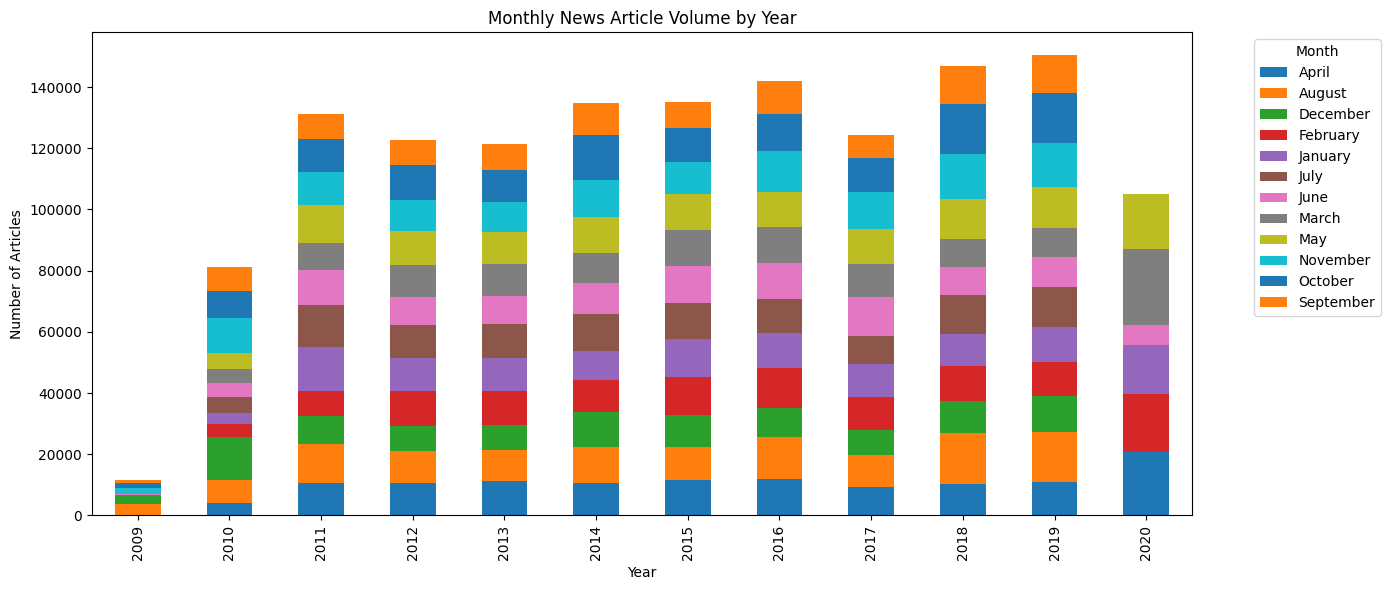

In [ ]:
# Articles per month across all years
monthly_counts = df.groupby(['year', 'month']).size().unstack(fill_value=0)

monthly_counts.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Monthly News Article Volume by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.legend(title='Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


3.1 Publication Trend for specifc 

Fed-related articles: 10030


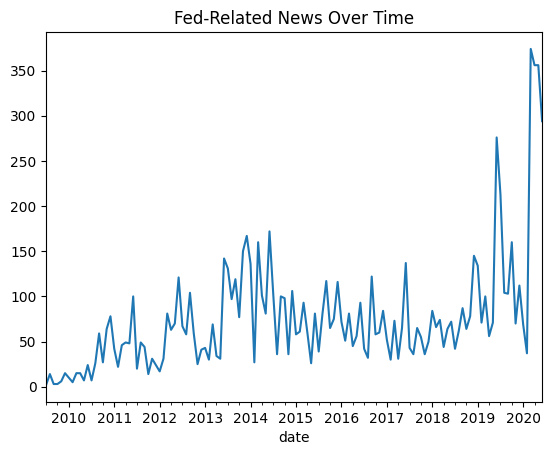

In [ ]:
# Example: Filter for Fed-related headlines
fed_news = df[df['headline'].str.contains('Federal Reserve|Fed', case=False)]
print(f"Fed-related articles: {len(fed_news)}")

# Plot Fed news over time
fed_news.set_index('date')['headline'].resample('ME').count().plot(title='Fed-Related News Over Time')
plt.show()

Text Analysis(Topic Modeling):

In [ ]:
df['cleaned_headline'].head()

0                         stock hit 52week high friday
1                      stock hit 52week high wednesday
2                              71 biggest mover friday
3                46 stock moving friday midday session
4    security maintains neutral agilent technology ...
Name: cleaned_headline, dtype: object

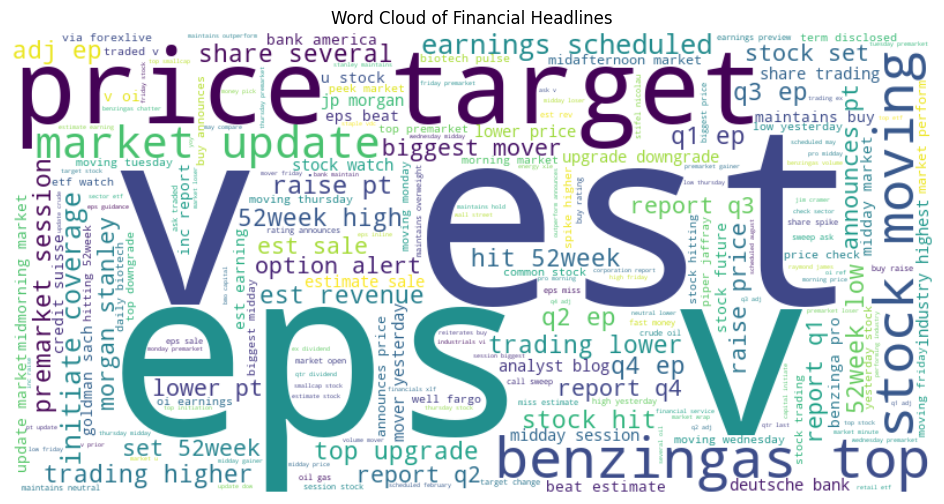

In [ ]:
from wordcloud import WordCloud

text = ' '.join(df['cleaned_headline'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Financial Headlines")
plt.show()


In [ ]:

# Initialize optimized TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(2, 3),  # Focus on meaningful phrases
    max_features=200,     # Increased from 100 for better coverage
    min_df=5,            # Ignore rare phrases
    max_df=0.85,         # Ignore overly common phrases
    stop_words=list(financial_stopwords)
)

# Transform text to TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(df['cleaned_headline'])

# Extract and display top phrases
feature_names = tfidf.get_feature_names_out()
keyword_scores = tfidf_matrix.sum(axis=0).A1
keyword_ranking = sorted(
    zip(feature_names, keyword_scores),
    key=lambda x: x[1], 
    reverse=True
)

print("Top Financial Phrases (Ranked by Importance):")
for rank, (phrase, score) in enumerate(keyword_ranking[:15], 1):
    print(f"{rank:>2}. {phrase.replace(' ', '_'):<25} Score: {score:.1f}")

Top Financial Phrases (Ranked by Importance):
 1. earnings_scheduled        Score: 27317.0
 2. price_target              Score: 21115.2
 3. initiate_coverage         Score: 20929.0
 4. benzingas_top             Score: 19389.2
 5. raise_pt                  Score: 19166.6
 6. market_update             Score: 14739.2
 7. share_several             Score: 14537.9
 8. option_alert              Score: 14459.0
 9. stock_moving              Score: 14051.2
10. lower_pt                  Score: 13394.3
11. trading_higher            Score: 13363.5
12. analyst_blog              Score: 13145.4
13. q1_eps                    Score: 12671.9
14. stock_watch               Score: 12651.7
15. trading_lower             Score: 12151.8


In [ ]:
#LDA analysis
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)  

# Display topics
for idx, topic in enumerate(lda.components_):
    print(f"Topic {idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[-5:]]))

Topic 0:
stock future report q3 q3 eps stock watch analyst blog
Topic 1:
trading lower biggest mover q4 eps q1 eps lower pt
Topic 2:
morning market report q2 q2 eps trading higher option alert
Topic 3:
52week low deutsche bank raise pt adj eps earnings scheduled
Topic 4:
market update benzingas top industry highest price target initiate coverage


Time Series Analysis 

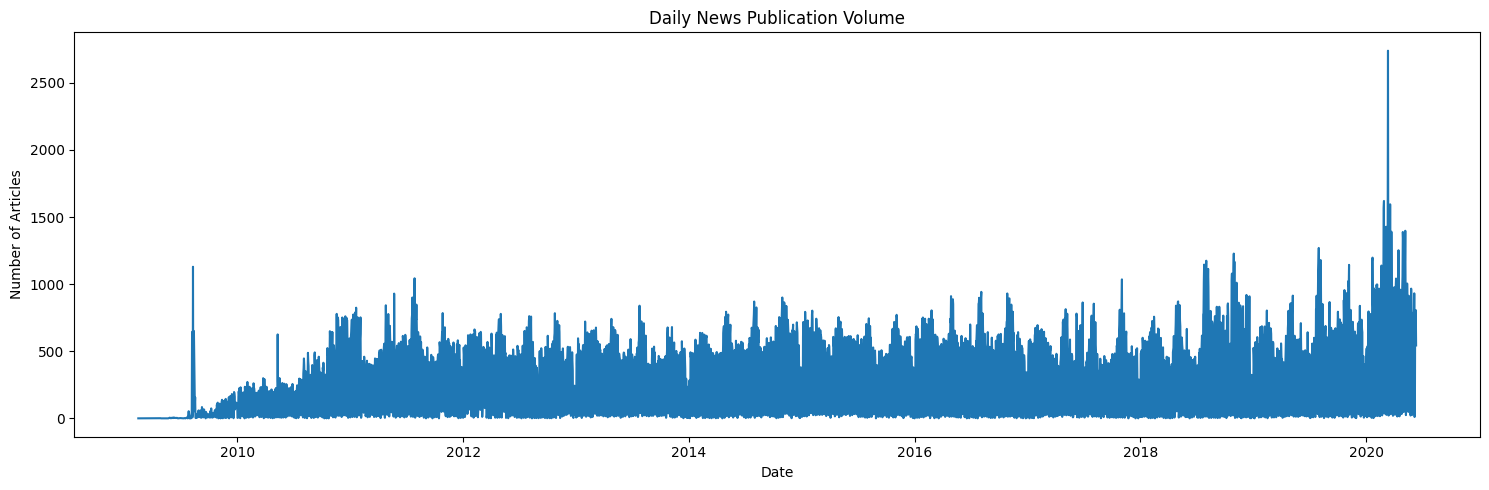

In [ ]:
daily_counts = df.groupby('published_date').size()

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
daily_counts.plot()
plt.title('Daily News Publication Volume')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()


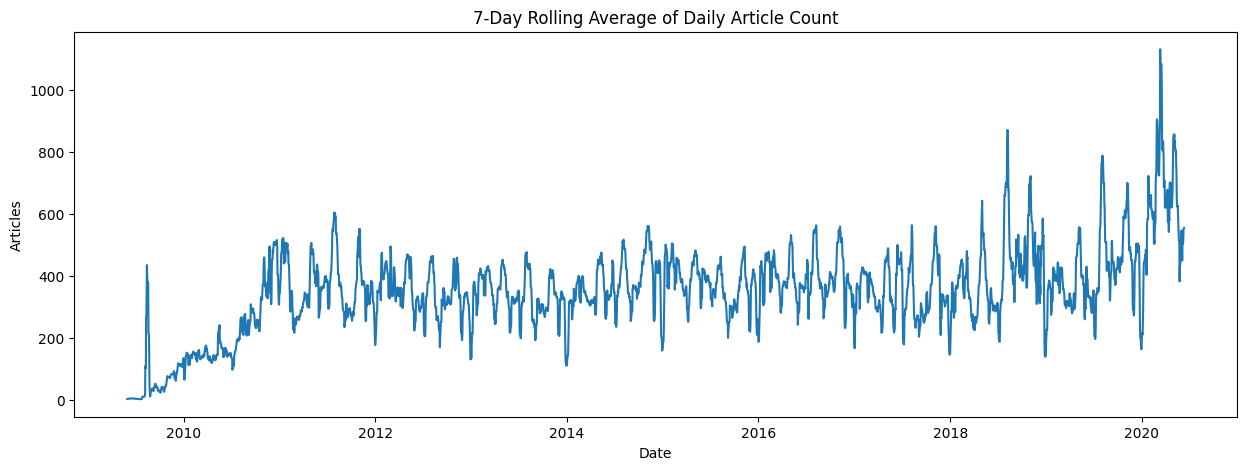

In [ ]:
daily_counts.rolling(window=7).mean().plot(figsize=(15, 5))
plt.title('7-Day Rolling Average of Daily Article Count')
plt.xlabel('Date')
plt.ylabel('Articles')
plt.show()


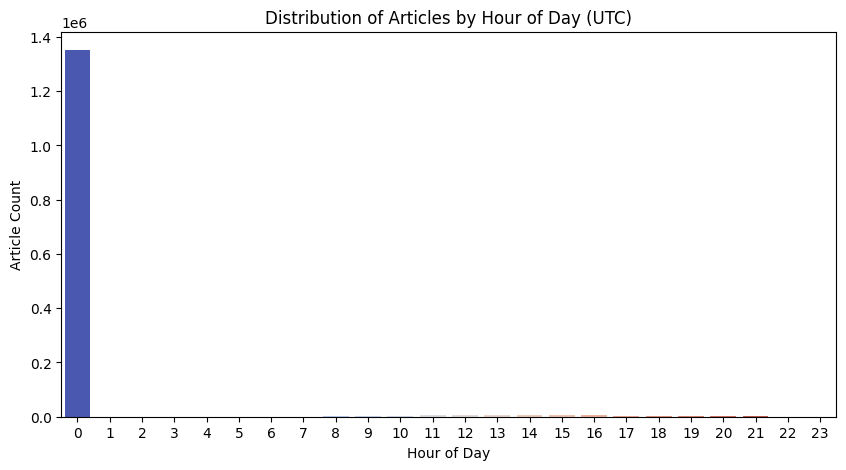

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='hour', data=df, palette='coolwarm', hue='hour', legend=False)
plt.title('Distribution of Articles by Hour of Day (UTC)')
plt.xlabel('Hour of Day')
plt.ylabel('Article Count')
plt.show()

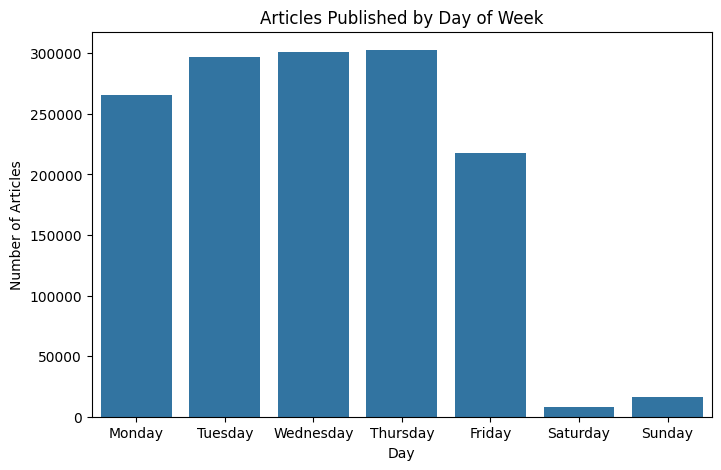

In [ ]:
day_counts = df['day_of_week'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(8, 5))
sns.barplot(x=day_counts.index, y=day_counts.values)
plt.title('Articles Published by Day of Week')
plt.xlabel('Day')
plt.ylabel('Number of Articles')
plt.show()


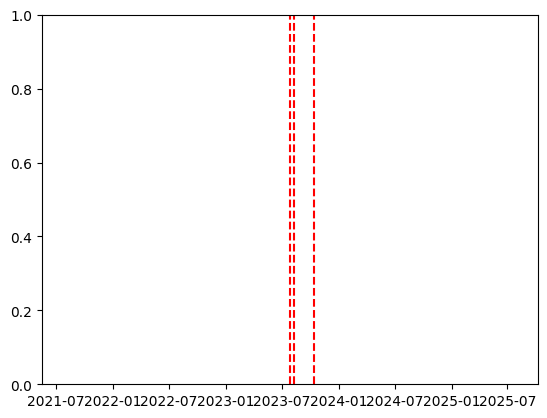

In [ ]:
important_dates = ['2023-07-27', '2023-08-10', '2023-10-13']  # example dates
for date in important_dates:
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--')


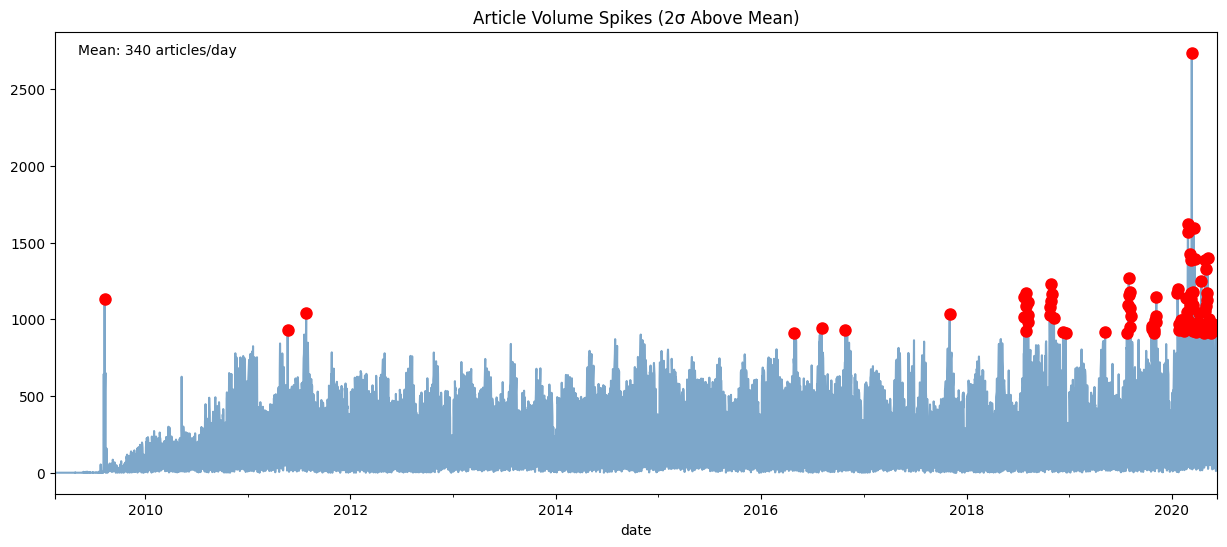

In [ ]:
# Identify volume spikes (2 std dev above mean)
daily = df.set_index('date').resample('D').size()

mean, std = daily.mean(), daily.std()
spikes = daily[daily > mean + 2*std]

# Plot spikes with annotations
plt.figure(figsize=(15, 6))
daily.plot(color='steelblue', alpha=0.7)
spikes.plot(marker='o', color='red', linestyle='', markersize=8)
plt.title('Article Volume Spikes (2σ Above Mean)')
plt.annotate(f'Mean: {mean:.0f} articles/day', 
            xy=(0.02, 0.95), xycoords='axes fraction')

# Compare with market events (example)
event_dates = {
    '2023-03-10': 'SVB Collapse',
    '2023-05-03': 'Fed Rate Hike',
    '2023-07-12': 'CPI Report'
}

for date, label in event_dates.items():
    if date in daily.index:
        plt.annotate(label, xy=(date, daily[date]), 
                    xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->'))
plt.show()

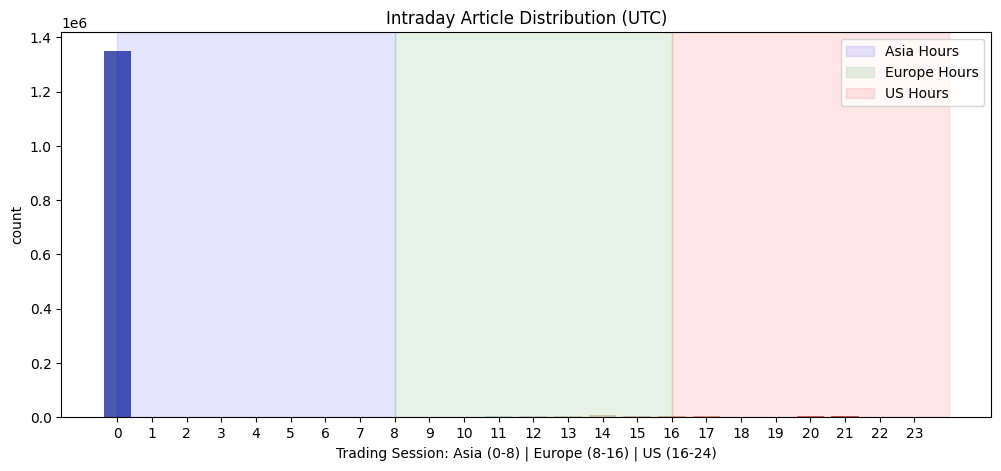

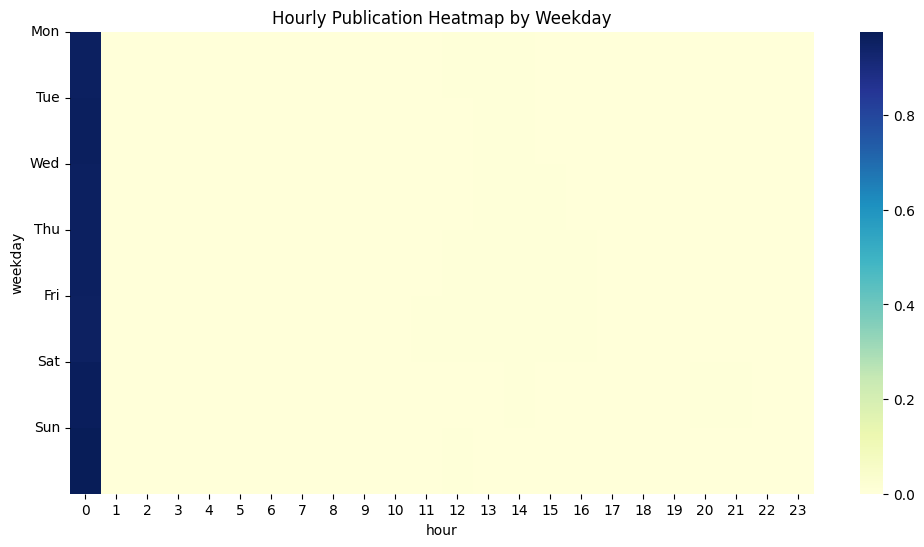

In [ ]:
#  Intraday Publishing Patterns

# Hourly distribution (UTC)
plt.figure(figsize=(12, 5))
sns.countplot(x='hour', data=df, hue='hour', palette='coolwarm', legend=False)
plt.title('Intraday Article Distribution (UTC)')
plt.xlabel('Trading Session: Asia (0-8) | Europe (8-16) | US (16-24)')
plt.axvspan(0, 8, alpha=0.1, color='blue', label='Asia Hours')
plt.axvspan(8, 16, alpha=0.1, color='green', label='Europe Hours')
plt.axvspan(16, 24, alpha=0.1, color='red', label='US Hours')
plt.legend()
plt.show()

# By weekday and hour
plt.figure(figsize=(12, 6))
df['weekday'] = df['date'].dt.dayofweek  # Monday=0
sns.heatmap(pd.crosstab(df['weekday'], df['hour'], normalize='index'), 
            cmap='YlGnBu')
plt.title('Hourly Publication Heatmap by Weekday')
plt.yticks(ticks=[0,1,2,3,4,5,6], 
           labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=0)
plt.show()

In [ ]:
# Optimal news monitoring windows
peak_hours = df.groupby('hour').size().nlargest(3).index
print(f"Top news hours: {sorted(peak_hours)} UTC")

Top news hours: [0, 13, 14] UTC


Publisher Analysis

1. Publisher Contribution Analysis

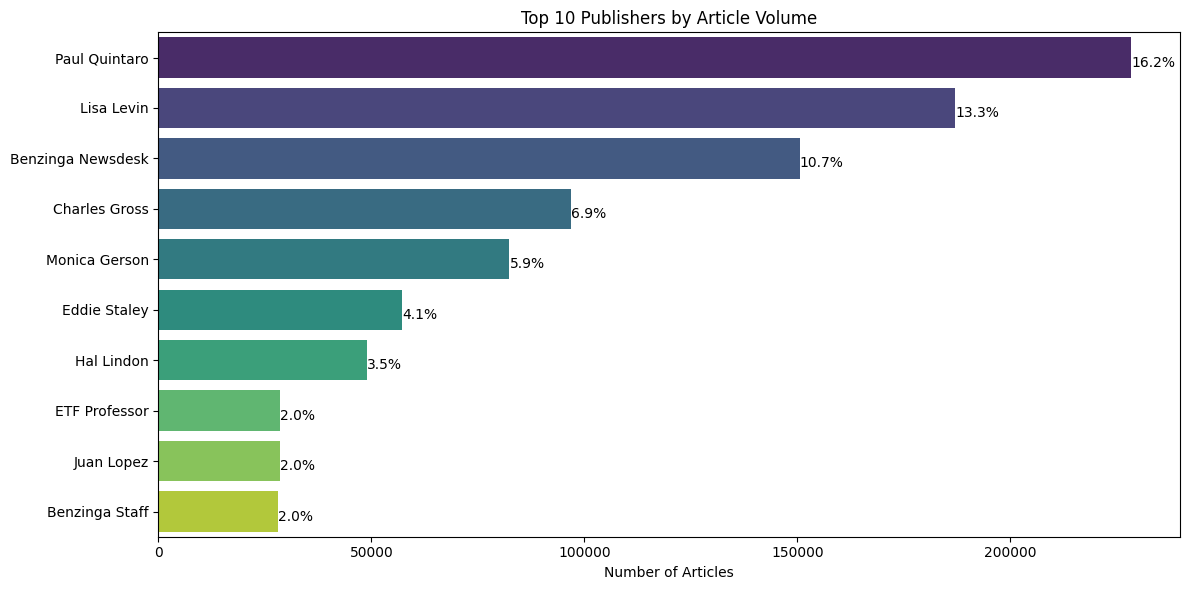

In [ ]:
# Top publishers by volume 
plt.figure(figsize=(12, 6))
top_publishers = df['publisher'].value_counts().nlargest(10)

# barplot with hue parameter
ax = sns.barplot(
    x=top_publishers.values, 
    y=top_publishers.index, 
    hue=top_publishers.index,  
    palette='viridis',
    legend=False  # Suppress legend
)

plt.title('Top 10 Publishers by Article Volume')
plt.xlabel('Number of Articles')
plt.ylabel('')

# Add percentages 
total = len(df)
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 5, p.get_y()+0.5, 
            f'{width/total:.1%}', 
            ha='left', va='center')
    
plt.tight_layout()
plt.show()

2. Publisher Specialization Analysis

In [ ]:
# # Transform the headlines into topic distributions
# topic_distributions = lda.transform(tfidf_matrix)

# # Add topic assignments to the dataframe
# Count articles per publisher
top_publishers = df['publisher'].value_counts().nlargest(10).index  # Change 5 to however many top publishers you want

# Filter to only top publishers
df_top_publishers = df[df['publisher'].isin(top_publishers)]

# Group by publisher and dominant topic
topic_by_pub = df_top_publishers.groupby(['publisher', 'dominant_topic']).size().unstack(fill_value=0)

# Normalize rows to show topic distribution per publisher
topic_share = topic_by_pub.div(topic_by_pub.sum(axis=1), axis=0)

topic_share

dominant_topic,0,1,2,3,4
publisher,,,,,
Benzinga Newsdesk,0.441635,0.186033,0.171593,0.163140,0.037599
Benzinga Staff,0.778722,0.061677,0.010742,0.073664,0.075194
Charles Gross,0.751148,0.032316,0.183610,0.007123,0.025803
ETF Professor,0.713433,0.003510,0.022711,0.002703,0.257643
Eddie Staley,0.669351,0.097198,0.063384,0.048643,0.121424
Hal Lindon,0.694171,0.109833,0.083593,0.059841,0.052562
Juan Lopez,0.159399,0.139004,0.118398,0.196955,0.386244
Lisa Levin,0.219138,0.255666,0.070019,0.257961,0.197216
Monica Gerson,0.423452,0.035118,0.059286,0.256919,0.225225


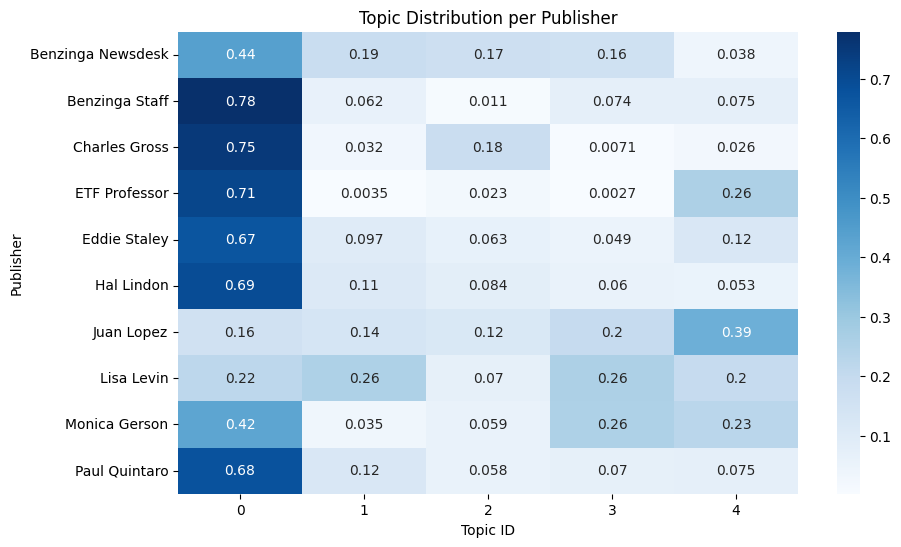

In [ ]:

plt.figure(figsize=(10, 6))
sns.heatmap(topic_share, annot=True, cmap='Blues')
plt.title("Topic Distribution per Publisher")
plt.ylabel("Publisher")
plt.xlabel("Topic ID")
plt.show()


In [ ]:
# Show top keywords per topic
n_keywords = 10  # Adjust as needed
topic_labels = []

print("Top Keywords per Topic:")
for idx, topic in enumerate(lda.components_):
    top_keywords = [feature_names[i] for i in topic.argsort()[-n_keywords:][::-1]]
    label = ", ".join(top_keywords)
    topic_labels.append(f"Topic {idx}: {label}")
    print(f"Topic {idx}: {label}")


Top Keywords per Topic:
Topic 0: analyst blog, stock watch, q3 eps, report q3, stock future, common stock, report q3 eps, market perform, biggest midday, peek market
Topic 1: lower pt, q1 eps, q4 eps, biggest mover, trading lower, bank america, report q4, mover yesterday, biggest mover yesterday, report q1
Topic 2: option alert, trading higher, q2 eps, report q2, morning market, share several, report q2 eps, benzinga pro, performing industry, oi earnings
Topic 3: earnings scheduled, adj eps, raise pt, deutsche bank, 52week low, morgan stanley, hit 52week, stock hit, stock hit 52week, 52week high
Topic 4: initiate coverage, price target, industry highest, benzingas top, market update, jp morgan, top upgrade, benzingas top upgrade, goldman sachs, credit suisse


In [ ]:
# Replace column names in topic_share with interpreted labels
topic_share.columns = [
    "Analyst Commentary & Market Outlook",
    "Stock Downgrades & Movers",
    "Options Activity & Earnings Beats",
    "Institutional Ratings & Earnings Events",
    "Analyst Coverage & Price Targets"
]

# View the updated table
topic_share.head()


,Analyst Commentary & Market Outlook,Stock Downgrades & Movers,Options Activity & Earnings Beats,Institutional Ratings & Earnings Events,Analyst Coverage & Price Targets
publisher,,,,,
Benzinga Newsdesk,0.441635,0.186033,0.171593,0.163140,0.037599
Benzinga Staff,0.778722,0.061677,0.010742,0.073664,0.075194
Charles Gross,0.751148,0.032316,0.183610,0.007123,0.025803
ETF Professor,0.713433,0.003510,0.022711,0.002703,0.257643
Eddie Staley,0.669351,0.097198,0.063384,0.048643,0.121424


In [ ]:
# Get top specialized topic per publisher
specialized_topic = topic_share.idxmax(axis=1)
print(specialized_topic)


publisher
Benzinga Newsdesk        Analyst Commentary & Market Outlook
Benzinga Staff           Analyst Commentary & Market Outlook
Charles Gross            Analyst Commentary & Market Outlook
ETF Professor            Analyst Commentary & Market Outlook
Eddie Staley             Analyst Commentary & Market Outlook
Hal Lindon               Analyst Commentary & Market Outlook
Juan Lopez                  Analyst Coverage & Price Targets
Lisa Levin           Institutional Ratings & Earnings Events
Monica Gerson            Analyst Commentary & Market Outlook
Paul Quintaro            Analyst Commentary & Market Outlook
dtype: object


3. Email Domain Analysis (if publishers are emails)

In [ ]:
import re

# Check for presence of '@' in publisher names
df['is_email'] = df['publisher'].str.contains('@')

# Extract domain from email publishers
df['email_domain'] = df['publisher'].apply(
    lambda x: x.split('@')[1] if '@' in x else None
)

# Top contributing domains
email_domain_counts = df['email_domain'].value_counts().head(10)
email_domain_counts


email_domain
benzinga.com              7937
gmail.com                  139
andyswan.com                 5
investdiva.com               2
tothetick.com                2
eosdetroit.io                1
forextraininggroup.com       1
stockmetrix.net              1
Name: count, dtype: int64

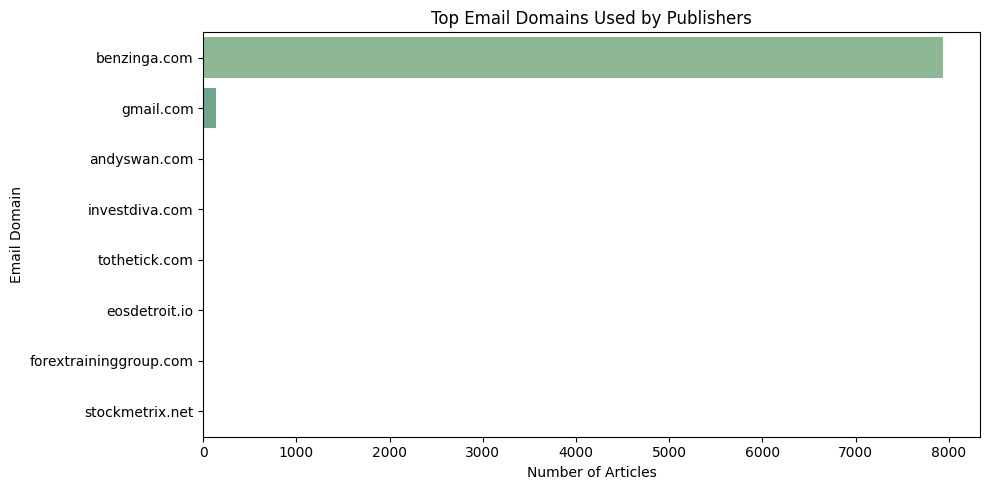

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(
    y=email_domain_counts.index, 
    x=email_domain_counts.values, 
    hue=email_domain_counts.index,  
    palette="crest",
    legend=False  
)
plt.title("Top Email Domains Used by Publishers")
plt.xlabel("Number of Articles")
plt.ylabel("Email Domain")
plt.tight_layout()
plt.show()

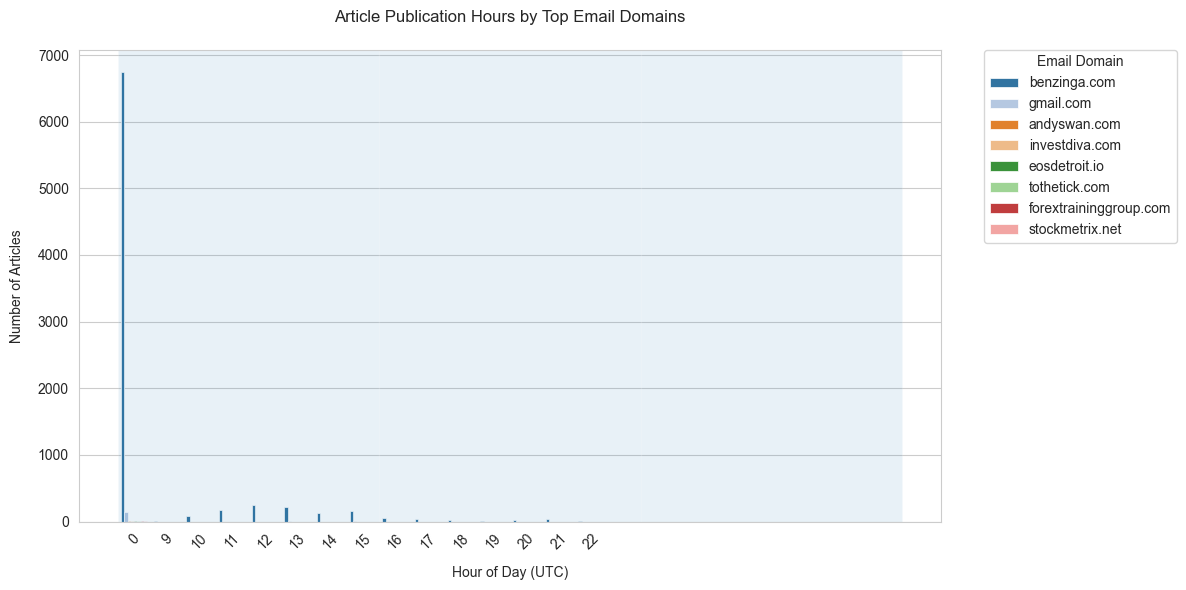

In [ ]:
# Filter for top domains and valid hours
top_domains = email_domain_counts.index.tolist()
domain_hour_df = df[df['email_domain'].isin(top_domains)].copy()

# Extract hour from datetime if needed
if 'hour' not in domain_hour_df.columns:
    domain_hour_df['hour'] = domain_hour_df['date'].dt.hour

# Create the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Use countplot with hue for domain-hour distribution
ax = sns.countplot(
    data=domain_hour_df,
    x='hour',
    hue='email_domain',
    palette='tab20',  # Color palette with good distinction
    edgecolor='white',
    linewidth=0.5
)

plt.title('Article Publication Hours by Top Email Domains', pad=20)
plt.xlabel('Hour of Day (UTC)', labelpad=10)
plt.ylabel('Number of Articles', labelpad=10)
plt.xticks(rotation=45)

# Improve legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(
    handles,
    labels,
    title='Email Domain',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

# Add trading session markers
trading_sessions = {
    'Asia': (0, 8),
    'Europe': (8, 16),
    'US': (16, 24)
}

for session, (start, end) in trading_sessions.items():
    plt.axvspan(start-0.5, end-0.5, alpha=0.1, label=f'{session} Hours')

plt.tight_layout()
plt.show()